In [29]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from random import seed
keras = tf.keras
execfile("./windowgenerator.py")
execfile("./tf_models.py")

DATA_PATHS = [
  # "data/mpi_saale_2023b.csv",
  "data/mpi_roof_2023b.csv", "data/mpi_roof_2023a.csv", "data/mpi_roof_2022b.csv", "data/mpi_roof_2022a.csv",
  "data/mpi_roof_2021b.csv", "data/mpi_roof_2021a.csv", "data/mpi_roof_2020b.csv", "data/mpi_roof_2020a.csv",
]
MAX_EPOCHS = 20
OUT_STEPS = 24
FEATURES = ['rain (mm)']
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

tf.random.set_seed(1224)

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

                        count         mean         std          min  \
p (mbar)              35073.0   989.947119    9.064962   952.510000   
T (degC)              35073.0    10.628599    7.945295   -19.780000   
Tpot (K)              35073.0   284.606650    8.058374   254.750000   
Tdew (degC)           35073.0     6.009288    6.233997   -21.170000   
rh (%)                35073.0    76.416957   19.239325    15.190000   
VPmax (mbar)          35073.0    14.484656    7.948789     1.260000   
VPact (mbar)          35073.0    10.135505    4.244260     1.120000   
VPdef (mbar)          35073.0     4.349049    5.624715     0.000000   
sh (g/kg)             35073.0     6.400885    2.697408     0.710000   
H2OC (mmol/mol)       35073.0    10.243910    4.298595     1.140000   
rho (g/m**3)          35073.0  1211.546979   38.091828  1101.120000   
max. wv (m/s)         35073.0     3.617064    2.440942     0.000000   
rain (mm)             35073.0     0.011599    0.165204     0.000000   
rainin

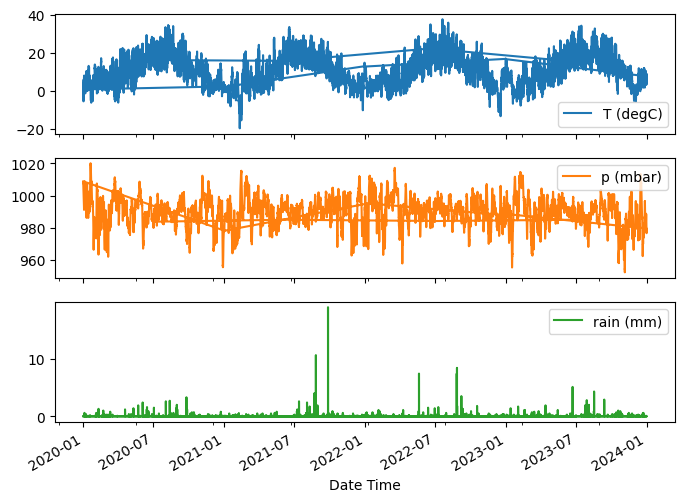

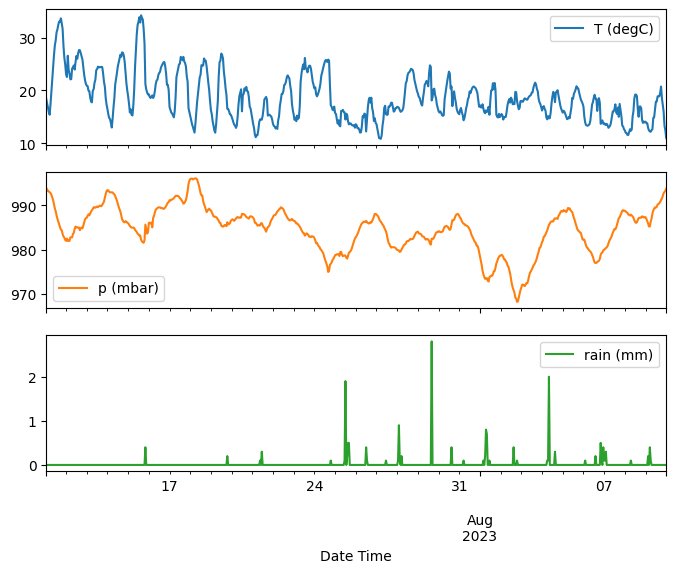

In [35]:
csvs = (pd.read_csv(f, encoding='ansi') for f in DATA_PATHS)
df = pd.concat(csvs, ignore_index=True)

df = df[5::6] # Slice down to every 6th record (every hour) starting from index 5 to configure for hourly predictions
date_time = pd.to_datetime(df.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')

# Feature engineering
# Combine wind velocity and direction scalars into a vector for ease of processing
wv = df.pop('wv (m/s)')
wd_rad = df.pop('wd (deg)') * np.pi / 180

df['Wx'] = wv * np.cos(wd_rad)
df['Wy'] = wv * np.sin(wd_rad)

timestamp_s = date_time.map(pd.Timestamp.timestamp)

# Day frequency values
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))

print(df.describe().transpose())

# Data split
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
df_train = df[0:int(0.7 * n)]
df_valid = df[int(0.7 * n):int(0.9 * n)]
df_test = df[int(0.9 * n):]
num_features = df.shape[1]

plot_cols = ["T (degC)", "p (mbar)", "rain (mm)"]
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][240:960]
plot_features.index = date_time[240:960]
_ = plot_features.plot(subplots=True)


C:\Users\Harrison\AppData\Local\Temp\ipykernel_6472\4006364998.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax.set_xticklabels(df.keys(), rotation=90)


                        count          mean  std        min       25%  \
p (mbar)              24551.0  7.851250e-15  1.0  -4.091401 -0.568241   
T (degC)              24551.0 -1.852256e-17  1.0  -3.701008 -0.768997   
Tpot (K)              24551.0  1.926346e-15  1.0  -3.586628 -0.779954   
Tdew (degC)           24551.0 -6.482896e-17  1.0  -4.312205 -0.755768   
rh (%)                24551.0  1.435498e-16  1.0  -3.335216 -0.635262   
VPmax (mbar)          24551.0  9.261280e-17  1.0  -1.622623 -0.760236   
VPact (mbar)          24551.0 -2.222707e-16  1.0  -2.121442 -0.814704   
VPdef (mbar)          24551.0  2.315320e-17  1.0  -0.727116 -0.637651   
sh (g/kg)             24551.0  1.018741e-16  1.0  -2.107572 -0.810060   
H2OC (mmol/mol)       24551.0  1.481805e-16  1.0  -2.115586 -0.811047   
rho (g/m**3)          24551.0 -1.111354e-16  1.0  -2.884252 -0.742618   
max. wv (m/s)         24551.0  2.361626e-16  1.0  -1.489391 -0.736229   
rain (mm)             24551.0 -1.504958e-17  1.0  -

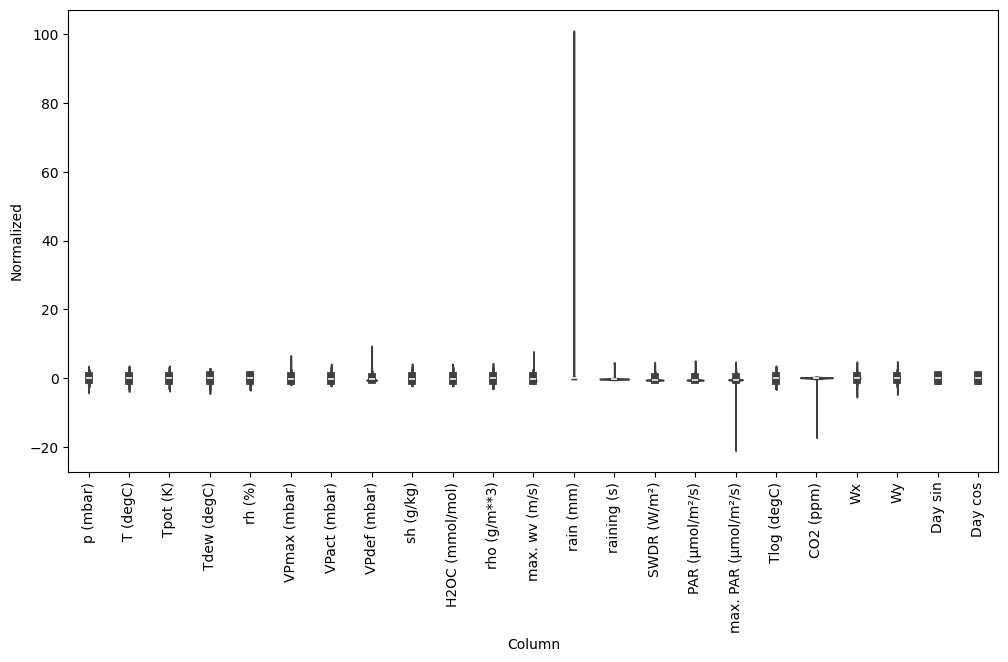

In [31]:
# Normalization
mean = df_train.mean()
std = df_train.std()
df_train = (df_train - mean) / std
df_valid = (df_valid - mean) / std
df_test = (df_test - mean) / std

df_std = (df - mean) / std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

print(df_train.describe().transpose())

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): ['rain (mm)']


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_11 (Reshape)            │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.9567 - mean_absolute_error: 0.1162 - val_loss: 0.2553 - val_mean_absolute_error: 0.1066
Epoch 2/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.9513 - mean_absolute_error: 0.1184 - val_loss: 0.2617 - val_mean_absolute_error: 0.1185
Epoch 3/20
766/766 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.9396 - mean_absolute_error: 0.1166 - val_loss: 0.2628 - val_mean_absolute_error: 0.1147
218/218 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2726 - mean_absolute_error: 0.1152
Validation performance: {'loss': 0.2628403306007385, 'mean_absolute_error': 0.11468137055635452}
Test performance: {'loss': 0.2671225070953369, 'mean_absolute_error': 0.11068197339773178}


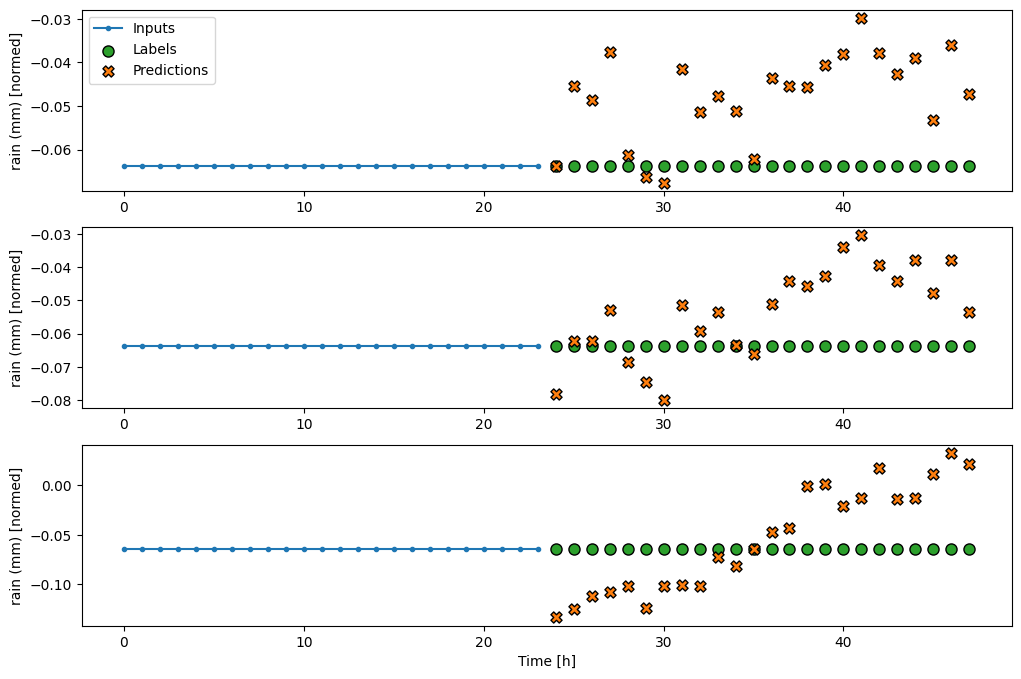

In [32]:
# Model initialization and training

window = WindowGenerator(
    input_width=24, label_width=24, shift=OUT_STEPS,
    label_columns = FEATURES,
    train_df=df_train, val_df=df_valid, test_df=df_test
)
print(window)

model = keras.Sequential([
    keras.layers.LSTM(32, return_sequences=False),
    keras.layers.Dense(OUT_STEPS * num_features, kernel_initializer=tf.initializers.zeros()),
    keras.layers.Reshape([OUT_STEPS, num_features])
])

model.summary()
compile_and_fit(model, window)

val_performance = model.evaluate(window.val, return_dict=True)
performance = model.evaluate(window.test, verbose=0, return_dict=True)


print("Validation performance:", val_performance)
print("Test performance:", performance)

for f in FEATURES:
    window.plot(model, f)

In [189]:
# Run to save the model's weights
model.save("./output/druid.keras")